# sensitvity to value of pseudo-count
 * testing the convergence of model `m5` for different pseudo-count values
 
### general information about the different growth/respiration versions

 * for the functional form of the different size-dependent growth and respiration formulations see [this notebook](sizedep_formulations.ipynb) 

## load data from files and plot

In [1]:
#%matplotlib notebook
import netCDF4 as nc4
import numpy as np

num_pseudocounts = [100, 1000, 10_000, 100_000, 1_000_000]

# load data
datafiles = {}
desc = {}

for npc in num_pseudocounts:
    datafiles['seaflow '+str(npc)] = 'data/SeaFlow_SizeDist_regrid-25-8.nc'
    desc['seaflow '+str(npc)] = 'SeaFlow dataset (pseudo count {})'.format(npc)
    datafiles['zinser '+str(npc)] = 'data/Zinser_SizeDist_calibrated-26-6.nc'
    desc['zinser '+str(npc)] = 'Zinser dataset (pseudo count {})'.format(npc)
    
itestfiles = {k:'data/Zinser_SizeDist_calibrated-26-6-itest.csv' for k in datafiles}

data_gridded = {}
for dataname in datafiles:
    data_gridded[dataname] = {}
    with nc4.Dataset(datafiles[dataname]) as nc:
        for var in nc.variables:
            data_gridded[dataname][var] = nc.variables[var][:]
    desc[dataname] += ' (m={data[m]}, $\Delta_v^{{-1}}$={data[delta_v_inv]})'.format(data=data_gridded[dataname])

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical', **cbarargs)
'''
for i,dataname in enumerate(data_gridded):
    nrows = 2
    fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(12,4*nrows))
    axs[0].set_title('raw data', size=20)
    
    ax = axs[0]
    ax.plot(data_gridded[dataname]['time'], data_gridded[dataname]['PAR'], color='gold')
    ax.set(ylabel='PAR')

    v_min = data_gridded[dataname]['v_min']
    delta_v = 1.0/data_gridded[dataname]['delta_v_inv']
    v = v_min * 2**(np.arange(data_gridded[dataname]['m'])*delta_v) 
    
    ax = axs[1]
    pc = ax.pcolormesh(data_gridded[dataname]['time'],v,data_gridded[dataname]['w_obs'])
    ax.set(ylabel='size ($\mu$m$^3$)')
    ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
axs[-1].set_xlabel=('time (minutes)')
'''
None

## process data and plot it

In [3]:
# prepare data for Stan model

if 'data' not in globals():
    data = {}
if 'mcmcs' not in globals():
    mcmcs = {}
if 'models' not in globals():
    models = {}

for dataname in data_gridded:
    dt = 20 # in units of minutes
    
    data[dataname] = {'dt':dt}
    for v in ('m','v_min','delta_v_inv'):
        data[dataname][v] = data_gridded[dataname][v]

    if 'seaflow' in dataname:
        limit_days = 1
        
        # new: average SeaFlow data in hourly bins
        binsize = 60 # in minutes
        numbins = int(np.ceil(data_gridded[dataname]['time'][-1]/binsize))
        
        data[dataname]['obs'] = np.full((data[dataname]['m'],numbins), fill_value=np.nan)
        data[dataname]['t_obs'] = np.full(numbins, fill_value=np.nan)
        
        i = 0
        for ibin in range(numbins):
            binind = np.logical_and(data_gridded[dataname]['time'] >= ibin*binsize,
                                    data_gridded[dataname]['time'] < (ibin+1)*binsize)
            if np.any(binind):
                # TODO we may want to make this a sum when dealing with counts
                data[dataname]['obs'][:,i] = np.mean(data_gridded[dataname]['w_obs'][:,binind], axis=1)
                data[dataname]['t_obs'][i] = (ibin+0.5) * binsize
                i += 1
        
        data[dataname]['obs'] = data[dataname]['obs'][:,:i]
        data[dataname]['t_obs'] = data[dataname]['t_obs'][:i]
        
        # median filter PAR
        # see: medianfilter_par.ipynb
        n = len(data_gridded[dataname]['PAR'])
        wsh = 30 # half of median filter window size; window size is 2*wsh+1
        par = np.array([np.median(data_gridded[dataname]['PAR'][max(0,i-wsh):min(n,i+wsh+1)]) for i in range(n)])
    else:
        limit_days = 2
        
        data[dataname]['obs'] = data_gridded[dataname]['w_obs']
        data[dataname]['t_obs'] = data_gridded[dataname]['time']
        par = data_gridded[dataname]['PAR']
        
    if limit_days > 0:
        limit_minutes = limit_days*1440
        
        ind_obs = data[dataname]['t_obs'] < limit_minutes
        data[dataname]['t_obs'] = data[dataname]['t_obs'][ind_obs]
        data[dataname]['obs'] = data[dataname]['obs'][:,ind_obs]
        
        data[dataname]['nt'] = int(limit_minutes//data[dataname]['dt'])

    data[dataname]['nt_obs'] = data[dataname]['t_obs'].size
    
    ## load cross-validation testing indices and add them to data
    #data[dataname]['i_test'] = np.loadtxt(itestfiles[dataname]).astype(int)
    ## remove last index, so that dimensions agree
    #data[dataname]['i_test'] = data[dataname]['i_test'][:-1]
    
    # set all indices to zero
    data[dataname]['i_test'] = np.zeros(data[dataname]['nt_obs'], dtype=int)
    
    # add light data
    t = np.arange(data[dataname]['nt'])*data[dataname]['dt']
    data[dataname]['E'] = np.interp(t, xp=data_gridded[dataname]['time'], fp=par)
    
    # for now, add pseudo-count data
    
    psc = int(dataname.split()[1])
    print('for "{}" psc={}'.format(dataname, psc))
    data[dataname]['obs_count'] = (psc*data[dataname]['obs']).astype(int)
    
    # consistency check
    if len(data[dataname]['i_test']) != data[dataname]['nt_obs']:
        raise ValueError('Invalid number of testing indices for "{}" (expected {}, got {}).'.format(dataname,data[dataname]['nt_obs'],len(data[dataname]['i_test'])))

for "seaflow 100" psc=100
for "zinser 100" psc=100
for "seaflow 1000" psc=1000
for "zinser 1000" psc=1000
for "seaflow 10000" psc=10000
for "zinser 10000" psc=10000
for "seaflow 100000" psc=100000
for "zinser 100000" psc=100000
for "seaflow 1000000" psc=1000000
for "zinser 1000000" psc=1000000


In [4]:
'''
for i,dataname in enumerate(data):
    nrows = 2
    fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(12,4*nrows))
    axs[0].set_title('processed data', size=20)
    
    ax = axs[0]
    t = np.arange(data[dataname]['nt'])*data[dataname]['dt']
    ax.plot(t, data[dataname]['E'], color='gold')
    ax.set(ylabel='E')

    v_min = data[dataname]['v_min']
    delta_v = 1.0/data[dataname]['delta_v_inv']
    v = v_min * 2**(np.arange(data[dataname]['m'])*delta_v) 
    
    ax = axs[1]
    pc = ax.pcolormesh(data[dataname]['t_obs'],v,data[dataname]['obs'])
    ax.set(ylabel='size ($\mu$m$^3$)')
    ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
    ax.set_xlim(left=0.0)
axs[-1].set_xlabel('time (minutes)')
'''
None

## run model

In [5]:
import pystan
import re

desc_model = {
    's1':'m5',
    's2':'m5 mlmn',
}
# preparing for some regular expression magic
model_code_replacements = {
    's1':(),
    's2':(),
    's3':(),
    's4':(),
    's5':(),
    's6':(),
    's7':(),
    's8':(),
    's9':(),
}
model_stan_key = {
    's1':'c5',
    's2':'c5mlmn',
}
stan_files = {
    'c1':'stancode_gallery1/matrixmodel_multinom_estinilnorm_freedelta_normparam_trackgrowth_xval.stan',
    'c2':'stancode_gallery1/matrixmodel_multinom_estinilnorm_monodelta_normparam_trackgrowth_xval.stan',
    'c3':'stancode_gallery1/matrixmodel_multinom_estinilnorm_monodelta_gammaiv6_normparam_trackgrowth_xval.stan',
    'c4':'stancode_gallery1/matrixmodel_multinom_estinilnorm_monodelta_respv1_normparam_trackgrowth_xval.stan',
    'c5':'stancode_gallery1/matrixmodel_multinom_estinilnorm_monodelta_respv2_normparam_trackgrowth_xval.stan',
    'c5mlmn':'stancode_gallery1/mlmn_version/matrixmodel_mlmultinom_estinilnorm_monodelta_respv2_normparam_trackgrowth_xval.stan',
    'c6':'stancode_gallery1/matrixmodel_multinom_estinilnorm_monodelta_respiv6_normparam_trackgrowth_xval.stan',
    'c7':'stancode_gallery1/matrixmodel_multinom_estinilnorm_monodelta_respiv7_normparam_trackgrowth_xval.stan',
    'c8':'stancode_gallery1/matrixmodel_multinom_estinilnorm_monodelta-lightsig_respiv6_normparam_trackgrowth_xval.stan',
    'c9':'stancode_gallery1/matrixmodel_multinom_estinilnorm_monodelta-lightsig_respiv7_normparam_trackgrowth_xval.stan',
    'c10':'stancode_gallery1/matrixmodel_multinom_estinilnorm_monodelta-lightsig_respv2_normparam_trackgrowth_xval.stan',
    'c56':'stancode/matrixmodel_multinom_estinilnorm_monodelta_resp_gammaiv6_normparam_trackgrowth_xval.stan',
    'c57':'stancode/matrixmodel_multinom_estinilnorm_monodelta_resp_gammaiv7_normparam_trackgrowth_xval.stan',
}

refit_required = {}
stan_base_code = {}
for key,stan_file in stan_files.items():
    with open(stan_file) as f:
        stan_base_code[key] = f.read()

stan_code = {}
for name in desc_model:
    code_split = stan_base_code[model_stan_key[name]].split('\n')
    code_split_new = []
    for line in code_split:
        line_new = line
        for replacement in model_code_replacements[name]:
            m = re.match(replacement[0],line_new)
            if m:
                line_new = m.groups(0)[0]+replacement[1]
                print('{}: patching in "{}"'.format(name, line_new))
        code_split_new.append(line_new)
                
    stan_code[name] = '\n'.join(code_split_new)

for name in desc_model:
    refit_required[name] = True
    if name in models and models[name].model_code == stan_code[name]:
        print('{}: unchanged code, not recompiling'.format(name))
        refit_required[name] = False
    else:
        if name in models:
            print('{}: code change detected, recompiling'.format(name))
        else:
            print('{}: compiling'.format(name))
        models[name] = pystan.StanModel(model_code=stan_code[name], model_name=name, obfuscate_model_name=False)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL s1 NOW.


s1: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL s2 NOW.


s2: compiling


In [6]:
import time
refit_all = False

def get_max_rhat(fit):
    s = fit.summary()
    irhat = s['summary_colnames'].index("Rhat")
    return np.nanmax(s['summary'][:,irhat])

def get_mean_rhat(fit):
    s = fit.summary()
    irhat = s['summary_colnames'].index("Rhat")
    return np.nanmean(s['summary'][:,irhat])

if 'maxrhats' not in globals():
    maxrhats = {}
if 'meanrhats' not in globals():
    meanrhats = {}
if 'sampling_time' not in globals():
    sampling_time = {}

    
try_again = False

# run a bunch of experiments -- this may take a while
for name in models:
    if name not in maxrhats:
        maxrhats[name] = {}
    if name not in meanrhats:
        meanrhats[name] = {}
    if name not in sampling_time:
        sampling_time[name] = {}
    for dataname in data:
        if dataname not in maxrhats[name]:
            maxrhats[name][dataname] = []
        if dataname not in meanrhats[name]:
            meanrhats[name][dataname] = []
        if dataname not in sampling_time[name]:
            sampling_time[name][dataname] = []
        if name in mcmcs:
            if dataname in mcmcs[name] and not refit_all and not refit_required[name]:
                print('{} ({})'.format(name, desc_model[name])) 
                print('\n'.join(x for x in mcmcs[name][dataname].__str__().split('\n') if 'mod_obspos' not in x and 'theta' not in x and 'w_ini' not in x and 'incr' not in x))
                rhat_max = get_max_rhat(mcmcs[name][dataname])
                if try_again and rhat_max >= 1.1:
                    print('{}: found Rhat={:.3f}, trying again'.format(name,rhat_max))
                else:
                    continue
        else:
            mcmcs[name] = {}
        for itry in range(3):
            t0 = time.time()
            mcmcs[name][dataname] = models[name].sampling(data=data[dataname], iter=2000)
            sampling_time[name][dataname].append(time.time() - t0) # in seconds
            meanrhats[name][dataname].append(get_mean_rhat(mcmcs[name][dataname]))
            # get max Rhat
            rhat_max = get_max_rhat(mcmcs[name][dataname])
            maxrhats[name][dataname].append(rhat_max)
            if rhat_max < 1.1:
                break
            print('{}: in try {}/3 found Rhat={:.3f}, trying again'.format(name,itry+1,rhat_max))
        print('{} ({})'.format(name, desc_model[name])) 
        print('\n'.join(x for x in mcmcs[name][dataname].__str__().split('\n') if 'mod_obspos' not in x and 'theta' not in x and 'w_ini' not in x and 'incr' not in x))

s1 (m5)
Inference for Stan model: s1.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         0.51  4.6e-3    0.2   0.22   0.36   0.48   0.61   0.98   1850    1.0
gamma_max            1.73    0.01   0.44   1.25   1.45   1.59   1.86   2.91   1297    1.0
rho_max              0.03  4.2e-4   0.02 1.1e-3 9.8e-3   0.02   0.04   0.09   3237    1.0
E_star             702.02   19.82 686.51  20.74 151.46 478.02 1049.6 2481.6   1200    1.0
divrate              0.77  1.2e-3   0.06   0.64   0.72   0.76   0.81    0.9   2878    1.0
delta_max[1]         0.02  3.5e-4   0.02 7.2e-4 7.4e-3   0.02   0.03   0.08   3903    1.0
delta_max[2]         1.04  4.0e-3   0.18   0.71   0.92   1.04   1.16   1.41   1909    1.0
delta_max[3]         1.42  4.0e-3   0.21   1.04   1.26    1.4   1.56   1.85   2806    1.0
delta_max[4]         1.98  5.5e-3 

s1: in try 1/3 found Rhat=1.144, trying again


s1: in try 2/3 found Rhat=1.151, trying again


s1: in try 3/3 found Rhat=1.172, trying again
s1 (m5)
Inference for Stan model: s1.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda          0.3  4.6e-3   0.08   0.17   0.24   0.29   0.35   0.49    332   1.01
gamma_max            1.39  1.7e-3   0.04   1.31   1.36   1.39   1.41   1.47    627    1.0
rho_max              0.01  5.2e-4   0.01 4.4e-4 4.8e-310.0e-3   0.02   0.04    385   1.01
E_star              39.03    5.64  29.97   0.18   9.15  39.43   59.0 102.52     28   1.13
divrate              0.78  4.2e-3   0.03   0.73   0.76   0.77   0.79   0.83     39   1.11
delta_max[1]         0.18  1.3e-3   0.03   0.13   0.16   0.18   0.19   0.23    396   1.01
delta_max[2]         1.22  9.3e-3   0.08   1.09   1.17   1.22   1.28   1.38     66   1.07
delta_max[3]         1.49  8.6e-3   0.08   1.34   1.44   1.49   1.54   1.66   

s1 (m5)
Inference for Stan model: s1.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda          1.5  5.4e-3   0.36   0.91   1.24   1.47   1.72   2.28   4412    1.0
gamma_max            4.35  2.4e-3   0.12   4.15   4.27   4.34   4.43   4.61   2365    1.0
rho_max              1.51  6.5e-4   0.04   1.44   1.48   1.51   1.53   1.58   3208    1.0
E_star              74.56     0.2   9.78  55.76  67.97  74.26   80.7  95.63   2323    1.0
divrate              0.69  4.2e-4   0.03   0.64   0.67   0.69   0.71   0.75   4439    1.0
delta_max[1]         0.07  4.1e-4   0.02   0.03   0.06   0.07   0.09   0.11   2719    1.0
delta_max[2]          0.1  2.1e-4   0.01   0.07   0.09    0.1   0.11   0.12   4412    1.0
delta_max[3]         0.11  1.7e-4   0.01   0.09    0.1   0.11   0.12   0.13   4457    1.0
delta_max[4]         0.12  1.5e-4 

s1 (m5)
Inference for Stan model: s1.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         0.26  3.4e-3   0.06   0.16   0.21   0.25    0.3    0.4    346   1.01
gamma_max             1.4  8.7e-4   0.01   1.37   1.39    1.4   1.41   1.43    285   1.02
rho_max            1.1e-3  5.4e-5 1.1e-3 3.3e-5 3.6e-4 8.0e-4 1.6e-3 3.9e-3    406    1.0
E_star              39.61    0.36   5.83  28.82  35.48  39.54  43.45  51.79    256   1.01
divrate              0.77  3.4e-4 6.3e-3   0.76   0.76   0.77   0.77   0.78    344   1.01
delta_max[1]         0.21  4.3e-4 6.9e-3    0.2   0.21   0.21   0.21   0.22    257   1.01
delta_max[2]         1.23  1.3e-3   0.02   1.19   1.21   1.23   1.24   1.27    231   1.02
delta_max[3]         1.51  1.5e-3   0.02   1.47    1.5   1.51   1.53   1.56    275   1.02
delta_max[4]         2.06  1.9e-3 

s1: in try 1/3 found Rhat=13.140, trying again


s1: in try 2/3 found Rhat=158.892, trying again


s1: in try 3/3 found Rhat=33.061, trying again
s1 (m5)
Inference for Stan model: s1.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         0.32    0.08   0.12   0.13   0.21   0.31   0.46   0.55      3   2.48
gamma_max             1.4  8.3e-4 4.3e-3   1.39   1.39    1.4    1.4   1.41     27   1.12
rho_max            7.0e-4  6.3e-4 9.0e-4 4.0e-5 9.9e-5 2.2e-4 1.6e-3 2.3e-3      2   9.89
E_star              29.35   11.75  16.71   0.26  15.18  38.65  39.28  43.11      2  11.83
divrate              0.78    0.01   0.02   0.76   0.77   0.77   0.79   0.81      2  11.25
delta_max[1]         0.22  5.2e-3 7.6e-3   0.21   0.21   0.21   0.22   0.23      2   4.58
delta_max[2]         1.25    0.03   0.04   1.22   1.22   1.23   1.28   1.33      2  11.46
delta_max[3]         1.54    0.02   0.03   1.51   1.51   1.52   1.55    1.6  

s1: in try 1/3 found Rhat=1031.981, trying again


s1: in try 2/3 found Rhat=2034.419, trying again


s1: in try 3/3 found Rhat=692.339, trying again
s1 (m5)
Inference for Stan model: s1.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         1.46    1.43   2.02   0.19   0.24   0.34    2.7    5.3      2   37.8
gamma_max            1.98    0.72   1.01   1.39    1.4    1.4   2.65   3.77      2 123.82
rho_max            6.6e-5  6.2e-5 8.7e-5 3.6e-7 2.0e-6 2.5e-5 1.4e-4 2.1e-4      2 391.29
E_star             929.73  1106.2 1564.9   0.57  17.42  39.55 1977.4 3688.8      2 160.56
divrate              0.75    0.04   0.05   0.66   0.71   0.77   0.79   0.81      2 133.13
delta_max[1]         0.21    0.02   0.02   0.17   0.19   0.21   0.22   0.23      2  49.09
delta_max[2]          1.2    0.08   0.11   1.02   1.11   1.23   1.28   1.33      2   98.8
delta_max[3]         1.48    0.08   0.11   1.29   1.39   1.52   1.56    1.6 

s1: in try 1/3 found Rhat=18.966, trying again


s1: in try 2/3 found Rhat=19.810, trying again


s1: in try 3/3 found Rhat=2.141, trying again
s1 (m5)
Inference for Stan model: s1.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         1.15    0.33   0.53   0.24   0.54   1.28   1.53   2.03      3   2.14
gamma_max            4.21  4.1e-5 3.0e-3   4.21   4.21   4.21   4.22   4.22   5436    1.0
rho_max               1.5  1.8e-5 1.1e-3    1.5    1.5    1.5    1.5    1.5   3893    1.0
E_star               70.4  3.3e-3   0.26  69.89  70.23   70.4  70.58  70.92   6063    1.0
divrate              0.67  1.3e-5 8.2e-4   0.67   0.67   0.67   0.67   0.67   4058    1.0
delta_max[1]         0.15  3.8e-6 2.7e-4   0.15   0.15   0.15   0.15   0.15   4988    1.0
delta_max[2]         0.15  3.8e-6 2.6e-4   0.15   0.15   0.15   0.15   0.15   4972    1.0
delta_max[3]         0.15  3.8e-6 2.6e-4   0.15   0.15   0.15   0.15   0.15   

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s2: in try 1/3 found Rhat=1.817, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s2: in try 2/3 found Rhat=2.000, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s2: in try 3/3 found Rhat=1.831, trying again
s2 (m5 mlmn)
Inference for Stan model: s2.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         1.69    0.04    0.4    1.0   1.41   1.67   1.94   2.52     90   1.05
gamma_max            1.94    0.13    0.6   1.32   1.55   1.76   2.15    3.9     21   1.21
rho_max              0.02  2.3e-3   0.02 2.3e-3 9.6e-3   0.02   0.03   0.06     49   1.05
E_star             965.59  167.56 768.75  85.58 397.87 813.73 1327.8 3277.0     21   1.18
sigma              1259.2   73.04 286.13 574.61 1096.2 1265.5 1424.9 1821.2     15   1.28
divrate              0.73    0.02   0.06   0.63   0.69   0.73   0.77   0.87     14   1.35
delta_max[1]         0.03  6.6e-3   0.02 2.5e-3   0.01   0.02   0.04   0.07      8   1.38
delta_max[2]         1.16    0.04   0.18   0.82   1.05   1.16   1.28   1.

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s2: in try 1/3 found Rhat=2.665, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s2: in try 2/3 found Rhat=2.328, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s2: in try 3/3 found Rhat=3.616, trying again
s2 (m5 mlmn)
Inference for Stan model: s2.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         1.74    0.04   0.36   1.08   1.49   1.72   1.98   2.43    101   1.07
gamma_max            5.57     1.2   1.82   4.02   4.33   4.49   6.53   9.65      2   3.46
rho_max              1.36    0.04   0.12    1.1   1.29   1.38   1.44   1.57      9   1.83
E_star             138.49   71.74 108.79  42.98  59.28  74.53 210.53 371.33      2   3.62
sigma              1624.5   71.52 367.68 1027.8 1382.6 1580.6 1850.8 2535.0     26   1.19
divrate              0.81    0.03   0.08   0.63   0.76   0.82   0.86   0.97     10   1.67
delta_max[1]         0.03  2.7e-3   0.01   0.02   0.03   0.03   0.04   0.06     18   1.28
delta_max[2]         0.04  2.2e-3   0.01   0.02   0.03   0.04   0.05   0.

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s2: in try 1/3 found Rhat=1.404, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s2: in try 2/3 found Rhat=1.338, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s2: in try 3/3 found Rhat=1.305, trying again
s2 (m5 mlmn)
Inference for Stan model: s2.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         1.56    0.05   0.36    1.0   1.29   1.52   1.75   2.46     61   1.07
gamma_max            1.42    0.01   0.07   1.28   1.37   1.42   1.47   1.56     25   1.22
rho_max              0.01  1.7e-3   0.01 6.9e-4 4.1e-3 9.0e-3   0.02   0.04     45   1.09
E_star              56.23    7.91  63.73   0.68  21.07  41.44  67.54 238.92     65   1.06
sigma              559.88    8.72  56.45 459.98 518.55 555.52 597.61 682.74     42   1.09
divrate              0.74  5.4e-3   0.04   0.67   0.72   0.74   0.77   0.81     45   1.11
delta_max[1]         0.19  4.6e-3   0.03   0.13   0.17   0.19   0.21   0.24     44   1.08
delta_max[2]         1.17    0.01   0.09   0.99   1.11   1.18   1.23   1.

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s2 (m5 mlmn)
Inference for Stan model: s2.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         2.04    0.01   0.47   1.23   1.71   1.99   2.33   3.05   1372    1.0
gamma_max            4.31    0.02   0.33    3.9   4.09   4.24   4.45   5.11    304   1.02
rho_max               1.4  2.7e-3   0.07   1.27   1.35    1.4   1.44   1.53    605    1.0
E_star              89.01    1.44  25.74   50.7   71.8  85.06 102.05 147.29    318   1.01
sigma              394.32    1.43  38.63 324.94 368.51  391.6 417.94  479.5    728    1.0
divrate              0.65  1.3e-3   0.05   0.57   0.62   0.65   0.68   0.75   1262    1.0
delta_max[1]          0.1  1.0e-3   0.02   0.05   0.08    0.1   0.11   0.14    511    1.0
delta_max[2]         0.12  5.9e-4   0.02   0.09   0.11   0.12   0.13   0.16    899    1.0
delta_max[3]         0.13  3.

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s2 (m5 mlmn)
Inference for Stan model: s2.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         1.92    0.03   0.47    1.1    1.6   1.88   2.21    2.9    224   1.03
gamma_max            1.36  4.5e-3   0.06   1.24   1.32   1.36   1.41   1.49    196   1.02
rho_max            9.2e-3  6.3e-4 8.4e-3 3.4e-4 2.8e-3 6.6e-3   0.01   0.03    178   1.03
E_star              25.43    2.39  41.17   0.19   1.83  10.06  37.37 110.72    298   1.01
sigma              414.54    2.07  27.81 367.07 395.79 412.76 431.29 474.67    181   1.02
divrate              0.73  2.7e-3   0.03   0.67   0.71   0.73   0.76    0.8    155   1.02
delta_max[1]         0.21  3.6e-3   0.03   0.15   0.19   0.21   0.24   0.28     82   1.06
delta_max[2]         1.17  8.8e-3    0.1   0.98    1.1   1.16   1.23   1.37    119   1.03
delta_max[3]          1.5    

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s2 (m5 mlmn)
Inference for Stan model: s2.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         2.14  6.0e-3    0.5   1.31   1.79    2.1   2.45   3.21   6906    1.0
gamma_max            3.84  3.8e-3   0.16   3.61   3.73   3.82   3.92   4.24   1833    1.0
rho_max              1.33  1.3e-3   0.07   1.19   1.28   1.33   1.38   1.48   2991    1.0
E_star              63.69    0.41   17.7  37.79  50.72  60.65  74.17 105.28   1855    1.0
sigma              265.94    0.29  19.07 230.22 252.89 265.55 278.86 304.71   4335    1.0
divrate              0.67  7.0e-4   0.05   0.59   0.64   0.67    0.7   0.77   4692    1.0
delta_max[1]         0.18  2.7e-4   0.02   0.14   0.17   0.18   0.19   0.22   5282    1.0
delta_max[2]         0.19  2.6e-4   0.02   0.15   0.17   0.19    0.2   0.23   5245    1.0
delta_max[3]         0.19  2.

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s2: in try 1/3 found Rhat=1.123, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s2: in try 2/3 found Rhat=1.102, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s2: in try 3/3 found Rhat=1.122, trying again
s2 (m5 mlmn)
Inference for Stan model: s2.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         1.82    0.04   0.46   1.05   1.49   1.78   2.12   2.79    150   1.02
gamma_max            1.35  4.7e-3   0.06   1.21   1.31   1.35   1.39   1.47    180   1.04
rho_max            8.0e-3  6.6e-4 7.4e-3 2.7e-4 2.6e-3 5.7e-3   0.01   0.03    124   1.06
E_star              26.27    3.05  39.12   0.16   2.04  10.49  38.74 114.91    164   1.01
sigma              392.37    1.61  22.87 350.05 376.62 392.04 406.55 441.23    202   1.03
divrate              0.73  3.2e-3   0.03   0.66   0.71   0.73   0.75   0.79    102   1.03
delta_max[1]         0.22  2.2e-3   0.03   0.16    0.2   0.22   0.24   0.28    174   1.03
delta_max[2]         1.14    0.01   0.09   0.94   1.08   1.14    1.2   1.

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s2 (m5 mlmn)
Inference for Stan model: s2.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         2.16  8.0e-3   0.52    1.3   1.78   2.11   2.48   3.35   4247    1.0
gamma_max            3.83  4.4e-3   0.17   3.58   3.72    3.8    3.9   4.24   1453    1.0
rho_max              1.33  1.6e-3   0.07   1.18   1.28   1.33   1.38   1.47   2178    1.0
E_star               63.5     0.5  18.29  37.12  50.04  60.27  73.91  105.7   1352    1.0
sigma              254.76    0.29  17.28 221.26  242.7 254.31 266.33 290.15   3540    1.0
divrate              0.67  7.1e-4   0.05   0.59   0.64   0.67    0.7   0.77   4284    1.0
delta_max[1]         0.18  3.2e-4   0.02   0.15   0.17   0.18   0.19   0.22   3555    1.0
delta_max[2]         0.19  2.8e-4   0.02   0.16   0.18   0.19    0.2   0.23   4246    1.0
delta_max[3]          0.2  2.

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s2: in try 1/3 found Rhat=1.189, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s2: in try 2/3 found Rhat=1.199, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s2: in try 3/3 found Rhat=1.169, trying again
s2 (m5 mlmn)
Inference for Stan model: s2.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         1.66    0.05   0.41   0.95   1.34   1.65   1.94    2.5     71   1.04
gamma_max            1.35  5.4e-3   0.07   1.22   1.31   1.35   1.39   1.48    148   1.04
rho_max            8.1e-3  6.2e-4 7.7e-3 3.0e-4 2.6e-3 5.8e-3   0.01   0.03    152   1.01
E_star              16.08     2.3  26.21   0.35   1.78    4.5  21.04  84.35    129   1.04
sigma              385.56    2.54  26.01 328.44 368.55 388.13 403.91 430.77    105   1.02
divrate              0.74  2.8e-3   0.03   0.67   0.71   0.74   0.76    0.8    131   1.02
delta_max[1]         0.22  2.7e-3   0.03   0.17    0.2   0.22   0.24   0.28    114   1.03
delta_max[2]         1.16  9.0e-3   0.09   0.98    1.1   1.16   1.22   1.

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s2 (m5 mlmn)
Inference for Stan model: s2.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         2.16  6.9e-3   0.51   1.28   1.81   2.11   2.48   3.25   5302    1.0
gamma_max            3.83  5.0e-3   0.17   3.58   3.72    3.8    3.9   4.25   1143    1.0
rho_max              1.32  1.6e-3   0.08   1.18   1.27   1.32   1.37   1.47   2294    1.0
E_star              63.91    0.55  18.72   36.8  50.26  60.84  74.34 107.32   1179    1.0
sigma              253.59     0.3  17.54 219.65 241.82 253.27 265.44 289.06   3434    1.0
divrate              0.67  7.0e-4   0.05   0.58   0.64   0.67    0.7   0.77   4554    1.0
delta_max[1]         0.18  3.2e-4   0.02   0.15   0.17   0.18   0.19   0.22   3663    1.0
delta_max[2]         0.19  2.8e-4   0.02   0.16   0.18   0.19    0.2   0.23   4245    1.0
delta_max[3]          0.2  2.

## plot the results

In [7]:
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['legend.fontsize'] = 16
mpl.rcParams['axes.titlesize'] = 26
mpl.rcParams['figure.figsize'] = (24,12)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

maxrhats_final = {name:{dataname:get_max_rhat(mcmcs[name][dataname]) for dataname in data} for name in mcmcs}        

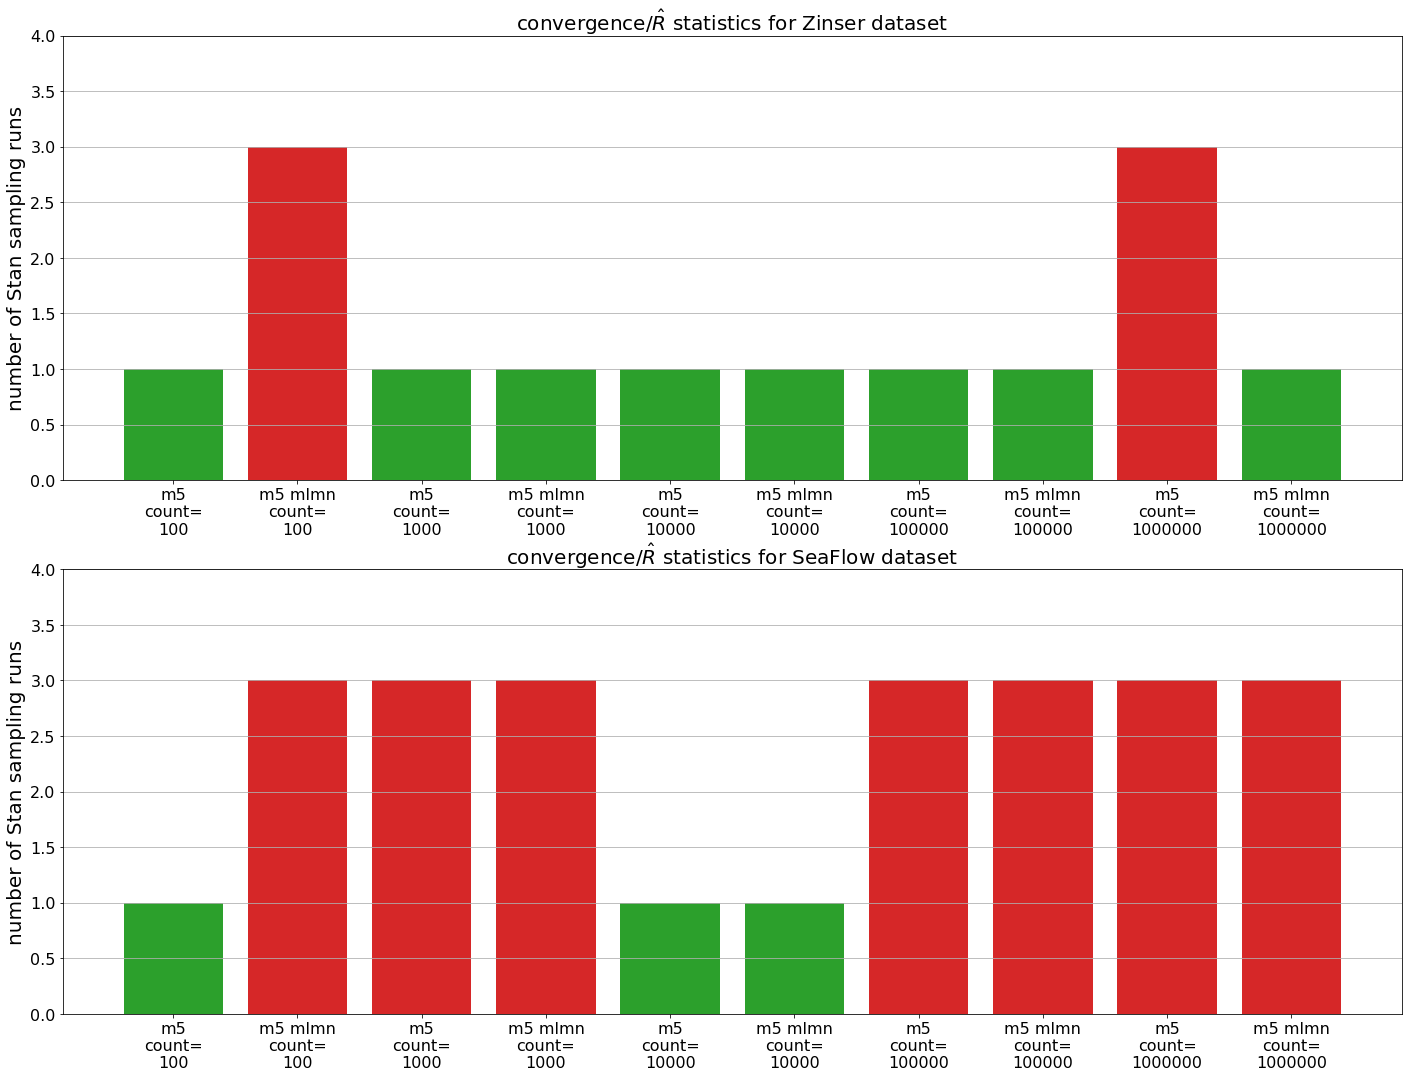

In [8]:
ylim_top = 0
for dataname in data:
    for name in mcmcs:
        ylim_top = max(ylim_top, len(maxrhats[name][dataname]))
ylim_top += 1

fig, axs = plt.subplots(nrows=2, figsize=(max(24,len(mcmcs)*4.5),2*9), sharey=True)

xticks = ([],[])
xticklabels = ([],[])

for idata,dataname in enumerate(data):
    if 'zinser' in dataname:
        iax = 0
    else:
        iax = 1
    
    ax = axs[iax]
    for i,name in enumerate(mcmcs):
        
        height_bad = sum(rh > 1.1 for rh in maxrhats[name][dataname])
        height_good = len(maxrhats[name][dataname]) - height_bad
        x = idata//2*len(mcmcs)+i
        
        ax.bar(x=x, height=height_bad, color='tab:red', label='max $\\\\hat{R}$ > 1.1')
        ax.bar(x=x, height=height_good, bottom=height_bad, color='tab:green', label='max $\\hat{R} \le$ 1.1')
        xticks[iax].append(x)
        xticklabels[iax].append(desc_model[name].replace(',',',\n') + '\ncount=\n' + dataname.split()[1])

for iax,ax in enumerate(axs.flat): 
    ax.set(ylabel='number of Stan sampling runs', xticks=xticks[iax], ylim=(0, ylim_top))
    ax.set_title('convergence/$\hat{{R}}$ statistics for {} dataset'.format(('Zinser','SeaFlow')[iax]), size=20)
    ax.set_xticklabels(xticklabels[iax])#, rotation=8)
    ax.grid(axis='y')

None